# Cluster Protein Copy Numbers - REDS Recall

In [ ]:
import re
from collections import defaultdict

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise
from rbc_gem_utils import (
    GEM_NAME,
    get_dirpath,
    read_cobra_model,
    show_versions,
    handle_msg
)

from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.3

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.3
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                                3.5
notebook                              7.4.4
openpyxl                              3.1.5
pandas                                2.3.1
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.4
scikit-learn                          1.7.0
scipy                                1.16.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip          25.1
setuptools 78.1.1
wheel      0.45

### Define organism, model, and dataset

In [27]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "REDSRecall"
genotype = "ATP11C_V972M"
grouped_data_key = 'Sample' 
grouped_data_key

'Sample'

### Set variables for columns keys and sample identification

In [28]:
sample_key = "SAMPLE ID"
operations = "|".join([x.capitalize() for x in ["mean", "median"]])
operation_re = re.compile(r"(?P<op>" + operations + r")\_(?P<group>\w+)")
donor_re = re.compile(rf"(?P<donor>S(?P<num>\d\d\d))")
sample_id_re = re.compile(
    r"(?!" + operations + r")" + donor_re.pattern
)

### Set figure options

In [29]:
save_figures = True
transparent = False
imagetype = "svg"

### Set paths

In [30]:
# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
processed_clusters_dirpath = (get_dirpath(use_temp="processed") / model_id / "Clustering" / organism / dataset_name)
# Ensure directories exist
processed_clusters_dirpath.mkdir(exist_ok=True, parents=True)

## Load RBC-GEM model

In [31]:
model_dirpath = get_dirpath("model")
model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")
model

Name,RBC_GEM
Memory address,254098e9810
Number of metabolites,2157
Number of reactions,3290
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Load copy numbers

In [32]:
# Load data for clustering
protein_dtype = "ProteinIntensities"
df_proteins = pd.read_csv(
    processed_data_dirpath / f"{protein_dtype}.csv",
    index_col=sample_key,
)

all_ids = list(df_proteins.index.unique())
operation_ids = [x for x in all_ids if operation_re.match(x)]
sample_ids = [x for x in all_ids if x not in operation_ids]

print(f"Number of measured samples: {len(sample_ids)}")
print(f"Number of operation samples: {len(operation_ids)}")
print(f"Number of models to generate: {len(all_ids)}")

Number of measured samples: 1910
Number of operation samples: 18
Number of models to generate: 1928


### Remove models based on data operations

In [33]:
df_data_samples = df_proteins[
    [
        not bool(operation_re.search(x)) 
        for x in df_proteins.index
    ]
].copy()
df_data_samples

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,114.106690,61.188179,16.998806,1.0,240.439072,0.000000,8.726534,0.000000,315.526550,60.624249,...,4.806035,0.000000,44.643505,130.273163,0.000000,30.318407,22.992273,0.000000,38.119408,202.467422
S001_D23,90.694664,18.855646,0.000000,0.0,234.999283,0.000000,30.381741,148.992706,342.803680,68.161423,...,3.503707,0.000000,28.674469,0.000000,0.000000,33.782383,159.744751,21.729137,38.118774,210.148560
S001_D42,123.064743,49.431454,61.730526,0.0,221.155167,0.000000,25.704966,0.000000,296.727020,83.098740,...,7.449622,1.478644,26.478333,139.307129,7.024934,45.400738,19.826700,22.173162,28.154861,191.642059
S002_D10,0.000000,0.000000,0.000000,0.0,267.438843,12.034687,24.897249,0.000000,0.000000,12.352674,...,12.975469,0.000000,53.475803,91.111374,0.000000,50.815300,0.000000,0.000000,113.735794,264.970459
S002_D23,64.492546,0.000000,490.452606,0.0,518.987244,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.578275,48.285789,48.756619,13.925104,0.000000,77.841980,0.000000,0.000000,129.577789,93.992775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S648_D42,77.322556,0.000000,0.000000,0.0,519.996765,0.000000,22.033518,0.000000,0.000000,15.774010,...,9.065331,0.000000,68.654137,0.000000,0.000000,43.890713,0.000000,0.000000,62.910065,98.207466
S649_D10,90.417908,0.000000,64.904564,0.0,121.021606,0.000000,8.485724,0.000000,170.234299,5.920393,...,4.922802,0.000000,18.535042,155.032333,0.000000,29.087191,19.722677,0.000000,35.296345,138.553513
S649_D42,95.081497,0.000000,0.000000,0.0,86.734108,0.000000,4.888623,32.385452,73.894814,67.835411,...,5.490839,13.410266,23.362236,132.913025,0.000000,34.493198,15.165656,72.291283,39.360321,99.929260


In [34]:
winsorize_limit = 0.05 # Set as 0 or None to prevent winsorization
export_data = True
dict_of_normalized_dfs = {}

### Normalize protein copy numbers across all samples

In [35]:
df = df_data_samples.copy()
filetag = []

if grouped_data_key == "Donor":
    df.index = [x.split("_")[0] for x in df.index]
    df = df.groupby(level=0).mean()
filetag = [grouped_data_key]

if winsorize_limit:
    # Winsorized
    df = df.clip(
        lower=df.quantile(winsorize_limit, axis=0),
        upper=df.quantile(1 - winsorize_limit, axis=0),
        axis=1,
    )
    filetag += ["WinPCT{:.0f}".format(100 * winsorize_limit)]

# Normalized
df_norm = df.sub(df.mean(axis=0), axis=1).div(df.std(ddof=1, axis=0), axis=1)
filetag += ["Z-score"]
filetag = "_".join(filetag)
print(f"Filetag: {filetag}")
df_norm

Filetag: Sample_WinPCT5_Z-score


,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,0.204175,2.676458,-0.493516,3.501067,-0.586355,-0.794563,-0.883735,-0.746079,1.613773,-0.333255,...,-0.769969,-0.385745,0.253789,0.915662,-0.470972,-1.104764,0.515920,-0.373638,-0.814281,0.775408
S001_D23,-0.109722,0.479840,-0.641978,-0.285478,-0.615249,-0.794563,0.468823,2.000563,1.814232,-0.209079,...,-1.067716,-0.385745,-0.473132,-0.864634,-0.470972,-0.850186,2.593169,-0.261395,-0.814313,0.889011
S001_D42,0.324280,2.066406,-0.102845,-0.285478,-0.688782,-0.794563,0.176717,-0.746079,1.475616,0.037014,...,-0.165574,-0.038115,-0.573101,1.039119,1.264863,0.003682,0.281005,-0.259102,-1.315697,0.615302
S002_D10,-1.325710,-0.498573,-0.641978,-0.285478,-0.442946,1.619098,0.126268,-0.746079,-0.705019,-1.128533,...,1.097783,-0.385745,0.655841,0.380482,-0.470972,0.401615,-1.190323,-0.373638,2.108895,1.699821
S002_D23,-0.461026,-0.498573,2.905318,-0.285478,0.893150,-0.794563,-1.428784,-0.746079,-0.705019,-1.224794,...,0.549721,3.435692,0.441021,-0.674335,-0.470972,2.136165,-1.190323,-0.373638,2.108895,-0.828921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S648_D42,-0.289008,-0.498573,-0.641978,-0.285478,0.898512,-0.794563,-0.052597,-0.746079,-0.705019,-1.072166,...,0.203821,-0.385745,1.346769,-0.864634,-0.470972,-0.107294,-1.190323,-0.373638,0.433184,-0.766586
S649_D10,-0.113432,-0.498573,-0.075124,-0.285478,-1.220640,-0.794563,-0.898776,-0.746079,0.546026,-1.224794,...,-0.743272,-0.385745,-0.934685,1.254018,-0.470972,-1.195250,0.273285,-0.373638,-0.956338,-0.169872
S649_D42,-0.050905,-0.498573,-0.641978,-0.285478,-1.229218,-0.794563,-1.123446,-0.149061,-0.161969,-0.214450,...,-0.613404,2.767015,-0.714948,0.951738,-0.470972,-0.797946,-0.064889,-0.000214,-0.751838,-0.741121


#### All proteins in dataset

In [36]:
if export_data:
    filepath = processed_clusters_dirpath / f"{filetag}.csv"
    df_norm.to_csv(filepath, index=True)
print("Standardized Range: ({:.4f}, {:.4f})".format(df_norm.min().min(), df_norm.max().max()))

df_norm

Standardized Range: (-2.3629, 4.2986)


,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,0.204175,2.676458,-0.493516,3.501067,-0.586355,-0.794563,-0.883735,-0.746079,1.613773,-0.333255,...,-0.769969,-0.385745,0.253789,0.915662,-0.470972,-1.104764,0.515920,-0.373638,-0.814281,0.775408
S001_D23,-0.109722,0.479840,-0.641978,-0.285478,-0.615249,-0.794563,0.468823,2.000563,1.814232,-0.209079,...,-1.067716,-0.385745,-0.473132,-0.864634,-0.470972,-0.850186,2.593169,-0.261395,-0.814313,0.889011
S001_D42,0.324280,2.066406,-0.102845,-0.285478,-0.688782,-0.794563,0.176717,-0.746079,1.475616,0.037014,...,-0.165574,-0.038115,-0.573101,1.039119,1.264863,0.003682,0.281005,-0.259102,-1.315697,0.615302
S002_D10,-1.325710,-0.498573,-0.641978,-0.285478,-0.442946,1.619098,0.126268,-0.746079,-0.705019,-1.128533,...,1.097783,-0.385745,0.655841,0.380482,-0.470972,0.401615,-1.190323,-0.373638,2.108895,1.699821
S002_D23,-0.461026,-0.498573,2.905318,-0.285478,0.893150,-0.794563,-1.428784,-0.746079,-0.705019,-1.224794,...,0.549721,3.435692,0.441021,-0.674335,-0.470972,2.136165,-1.190323,-0.373638,2.108895,-0.828921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S648_D42,-0.289008,-0.498573,-0.641978,-0.285478,0.898512,-0.794563,-0.052597,-0.746079,-0.705019,-1.072166,...,0.203821,-0.385745,1.346769,-0.864634,-0.470972,-0.107294,-1.190323,-0.373638,0.433184,-0.766586
S649_D10,-0.113432,-0.498573,-0.075124,-0.285478,-1.220640,-0.794563,-0.898776,-0.746079,0.546026,-1.224794,...,-0.743272,-0.385745,-0.934685,1.254018,-0.470972,-1.195250,0.273285,-0.373638,-0.956338,-0.169872
S649_D42,-0.050905,-0.498573,-0.641978,-0.285478,-1.229218,-0.794563,-1.123446,-0.149061,-0.161969,-0.214450,...,-0.613404,2.767015,-0.714948,0.951738,-0.470972,-0.797946,-0.064889,-0.000214,-0.751838,-0.741121


## Split data into subgroups using metadata
### Load metadata

In [37]:
df_metadata = pd.read_csv(
    processed_data_dirpath / "Metadata.csv",
    index_col=sample_key,
)

if grouped_data_key.endswith("Donor"):
    df_metadata.index = [x.split("_")[0] for x in df_metadata.index]
    df_metadata = df_metadata.groupby(level=0).agg(lambda x: list(x.unique()))
    df_metadata = df_metadata.explode(list(df_metadata.columns))

for c in df_metadata.columns:
    print(c)
df_metadata.index.name = sample_key
df_metadata

ATP11C_V972M
G6PD_V68M
AS
Gender
DONDB.ABO_RH
RBCOmics.Race.Ethnicity.Group
Age
BMI
Weight
Height
Hemolysis.volume
Hemolysis.hct
Hemolysis.storage_total_hb
Hemolysis.storage_pct_hemol
Hemolysis.pink_total_hb
Hemolysis.pink_pct_hemol
Recall.Transfer.Storage.Hemolysis
Recall.Transfer.Osmotic.Hemolysis
Recall.Transfer.Oxidative.Hemolysis
Adjusted.Storage.Hemolysis
Adjusted.Osmotic.Hemolysis
Adjusted.Oxidative.Hemolysis
CBC.WBC
CBC.RBC
CBC.HGB
CBC.HCT
CBC.MCV
CBC.RDW
CBC.PLT
Ferritin


,ATP11C_V972M,G6PD_V68M,AS,Gender,DONDB.ABO_RH,RBCOmics.Race.Ethnicity.Group,Age,BMI,Weight,Height,...,Adjusted.Osmotic.Hemolysis,Adjusted.Oxidative.Hemolysis,CBC.WBC,CBC.RBC,CBC.HGB,CBC.HCT,CBC.MCV,CBC.RDW,CBC.PLT,Ferritin
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,0.0,0.0,AS1,M,O+,CAUCASIAN,33,25.724339,195,73,...,51.412936,NaN,5.56,5.33,15.5,46.60,87.40,12.7,274.0,19.0
S001_D23,0.0,0.0,AS1,M,O+,CAUCASIAN,33,25.724339,195,73,...,51.412936,NaN,5.56,5.33,15.5,46.60,87.40,12.7,274.0,19.0
S001_D42,0.0,0.0,AS1,M,O+,CAUCASIAN,33,25.724339,195,73,...,51.412936,NaN,5.56,5.33,15.5,46.60,87.40,12.7,274.0,19.0
S002_D10,0.0,0.0,AS3,M,A+,HIGH,71,27.891291,200,71,...,72.000942,NaN,7.32,5.38,16.5,47.90,89.00,12.7,222.0,23.0
S002_D23,0.0,0.0,AS3,M,A+,HIGH,71,27.891291,200,71,...,72.000942,NaN,7.32,5.38,16.5,47.90,89.00,12.7,222.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S650_D23,0.0,0.0,AS1,F,A+,HIGH,62,24.293018,146,65,...,37.482130,18.510241,4.61,4.44,13.3,41.00,92.30,13.3,303.0,9.0
S650_D42,0.0,0.0,AS1,F,A+,HIGH,62,24.293018,146,65,...,37.482130,18.510241,4.61,4.44,13.3,41.00,92.30,13.3,303.0,9.0
S651_D10,0.0,0.0,AS3,M,B+,CAUCASIAN,43,24.629325,162,68,...,17.157164,26.019015,6.15,4.68,14.7,42.75,91.45,13.1,241.5,64.0


### Split by genotype

In [53]:
# Genotypes
verbose = True
dict_of_genotype_dfs = {}
if genotype not in df_metadata.columns:
    handle_msg(f"No genotype data for Genotype {genotype}\n", print_msg=verbose)
handle_msg(f"Splitting data for Genotype {genotype}", print_msg=verbose)
# Make directory
genotype_dir = processed_clusters_dirpath / genotype
genotype_dir.mkdir(exist_ok=True, parents=True)
# Drop NA values and save Genotype MetaData
df_genotype = df_metadata[genotype].dropna()
if export_data:
    df_genotype.to_csv(genotype_dir / f"{grouped_data_key}_Genotypes.csv", index=True)
# Split data by allele counts for proteins
handle_msg(f"Applying to normalized data for proteins", print_msg=verbose)
# Group samples by allele count for samples with allele count determined
df_samples_grouped = df_genotype.reset_index(drop=False).convert_dtypes().groupby(df_genotype.name).agg(list)
df_samples_grouped.loc["All"] = [list(df_genotype.index)]
handle_msg(f"Creating subgroups for allele counts: {list(df_samples_grouped.index)}", print_msg=verbose)
for allele_count, sample_ids in df_samples_grouped.iterrows():
    allele_key = f"Alleles{allele_count}"
    df_allele_samples = df_data_samples.loc[df_data_samples.index.isin(sample_ids.item())]
    df_allele_samples_norm = df_norm.loc[df_norm.index.isin(sample_ids.item())]
    df_allele_samples_norm = df_allele_samples_norm.dropna(how="all", axis=1).fillna(df_allele_samples_norm.mean(axis=0))
    # Save data
    if export_data:
        df_allele_samples.to_csv(genotype_dir / "{}.csv".format("_".join([protein_dtype, allele_key])), index=True)
        df_allele_samples_norm.to_csv(genotype_dir / "{}.csv".format("_".join([protein_dtype, allele_key, filetag])), index=True)

    dict_of_genotype_dfs[(genotype, allele_count)] = df_allele_samples_norm.copy()
    print(df_allele_samples_norm.shape)
print()

Splitting data for Genotype ATP11C_V972M
Applying to normalized data for proteins
Creating subgroups for allele counts: [0, 1, 2, 'All']
(1836, 1804)
(35, 1804)
(6, 1804)
(1877, 1804)



## Load data for clustering
### Cluster samples pre-grouped by allele count for representative models

In [14]:
def calculate_dunn_index(data, labels):
    # Calculate pairwise distances
    distances = pairwise.euclidean_distances(data)

    # Initialize variables for min_intercluster and max_intracluster
    min_intercluster = np.inf
    max_intracluster = 0

    unique_labels = np.unique(labels)

    # Compute maximum intra-cluster distance
    for label in unique_labels:
        cluster_points_indices = np.where(labels == label)[0]
        if len(cluster_points_indices) > 1:
            intra_cluster_distances = distances[np.ix_(cluster_points_indices, cluster_points_indices)]
            max_intracluster = max(max_intracluster, np.max(intra_cluster_distances))

    # Compute minimum inter-cluster distance
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i_indices = np.where(labels == unique_labels[i])[0]
            cluster_j_indices = np.where(labels == unique_labels[j])[0]
            inter_cluster_distances = distances[np.ix_(cluster_i_indices, cluster_j_indices)]
            min_intercluster = min(min_intercluster, np.min(inter_cluster_distances))

    if max_intracluster == 0: # Handle cases of single-point clusters or perfect overlap
        return np.inf
    else:
        return min_intercluster / max_intracluster

#### Allele count: 0

In [15]:
cluster_mapping = {}

In [16]:
allele_count = 0
verbose = True
data_original = dict_of_genotype_dfs[(genotype, allele_count)].copy()
data_original.index.name = sample_key
data_original.columns.name = "Proteins"
data_original

Proteins,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,0.204175,2.676458,-0.493516,3.501067,-0.586355,-0.794563,-0.883735,-0.746079,1.613773,-0.333255,...,-0.769969,-0.385745,0.253789,0.915662,-0.470972,-1.104764,0.515920,-0.373638,-0.814281,0.775408
S001_D23,-0.109722,0.479840,-0.641978,-0.285478,-0.615249,-0.794563,0.468823,2.000563,1.814232,-0.209079,...,-1.067716,-0.385745,-0.473132,-0.864634,-0.470972,-0.850186,2.593169,-0.261395,-0.814313,0.889011
S001_D42,0.324280,2.066406,-0.102845,-0.285478,-0.688782,-0.794563,0.176717,-0.746079,1.475616,0.037014,...,-0.165574,-0.038115,-0.573101,1.039119,1.264863,0.003682,0.281005,-0.259102,-1.315697,0.615302
S002_D10,-1.325710,-0.498573,-0.641978,-0.285478,-0.442946,1.619098,0.126268,-0.746079,-0.705019,-1.128533,...,1.097783,-0.385745,0.655841,0.380482,-0.470972,0.401615,-1.190323,-0.373638,2.108895,1.699821
S002_D23,-0.461026,-0.498573,2.905318,-0.285478,0.893150,-0.794563,-1.428784,-0.746079,-0.705019,-1.224794,...,0.549721,3.435692,0.441021,-0.674335,-0.470972,2.136165,-1.190323,-0.373638,2.108895,-0.828921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S648_D42,-0.289008,-0.498573,-0.641978,-0.285478,0.898512,-0.794563,-0.052597,-0.746079,-0.705019,-1.072166,...,0.203821,-0.385745,1.346769,-0.864634,-0.470972,-0.107294,-1.190323,-0.373638,0.433184,-0.766586
S649_D10,-0.113432,-0.498573,-0.075124,-0.285478,-1.220640,-0.794563,-0.898776,-0.746079,0.546026,-1.224794,...,-0.743272,-0.385745,-0.934685,1.254018,-0.470972,-1.195250,0.273285,-0.373638,-0.956338,-0.169872
S649_D42,-0.050905,-0.498573,-0.641978,-0.285478,-1.229218,-0.794563,-1.123446,-0.149061,-0.161969,-0.214450,...,-0.613404,2.767015,-0.714948,0.951738,-0.470972,-0.797946,-0.064889,-0.000214,-0.751838,-0.741121


#### K-means clustering
##### Determine optimal number of clusters for representative models

In [17]:
evaulation_metric_scores = defaultdict(dict)
dataframes_of_clusters = {}
dataframes_of_label_maps = {}
kmax = min(50, len(data_original) - 1)
verbose = False
for n_clusters in range(2, kmax + 1):
    
    kmeans = sklearn.cluster.KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=50,
        max_iter=int(1e9),
        tol=1e-12,
        verbose=0,
        random_state=44,
        algorithm="lloyd",
    )
    # Clustering occurs on columns, goal is to reduce sample number so data format is (n_features, n_samples)
    data_clustered = kmeans.fit_transform(data_original.values)
    # Inertia (Within-cluster sum-of-squares)
    inertia = kmeans.inertia_
    evaulation_metric_scores["Inertia"][n_clusters] = inertia
    # Silhouette Score
    evaulation_metric_scores["Silhouette Score"][n_clusters] = silhouette_score(
        data_clustered, # (n_samples, n_features)
        kmeans.labels_,
        metric='euclidean',
        sample_size=None,
        random_state=None,
    )
    # Davies-Bouldin Index
    evaulation_metric_scores["Davies-Bouldin Index"][n_clusters] = davies_bouldin_score(data_clustered, kmeans.labels_)
    # Calinski-Harabasz Index
    evaulation_metric_scores["Calinski-Harabasz Index"][n_clusters] = calinski_harabasz_score(data_clustered, kmeans.labels_)
    evaulation_metric_scores["Dunn Index"][n_clusters] = calculate_dunn_index(data_clustered, kmeans.labels_)
    if verbose:
        header = f"For K-means clustering: K = {n_clusters}"
        
        print(f"{header}\n{'='*len(header)}") 
        for metric_key in list(evaulation_metric_scores):
            score = evaulation_metric_scores[metric_key][n_clusters]
            print(f"{metric_key}: {score:.4f}")
        print()

    # Save as DataFame
    data_clustered = pd.DataFrame(data_clustered, index=data_original.index)
    data_clustered.index.name = "Proteins"
    data_clustered.columns.name = "Cluster"
    dataframes_of_clusters[n_clusters] = data_clustered
    dataframes_of_label_maps[n_clusters] = kmeans.labels_

#### Plot evaluation metric scores
##### Inertia
Measures the compactness of clusters by calculating the sum of squared distances between each data point and its centroid. Lower inertia generally indicates tighter, more cohesive clusters.
##### Silhouette Score
Measures how well each data point fits within its assigned cluster compared to other clusters. A higher score (closer to 1) indicates better clustering. 
##### Davies-Bouldin Index
Measures the average similarity between each cluster and its most similar cluster. A lower score indicates better separation between clusters. 
##### Calinski-Harabasz Index
Measures the ratio of between-cluster dispersion to within-cluster dispersion. A higher score indicates better clustering. 
##### Dunn Index:
Measures the ratio of the shortest distance between clusters to the largest distance within a cluster. A higher score indicates better separation and compactness. 

Number of samples to cluster: 1836


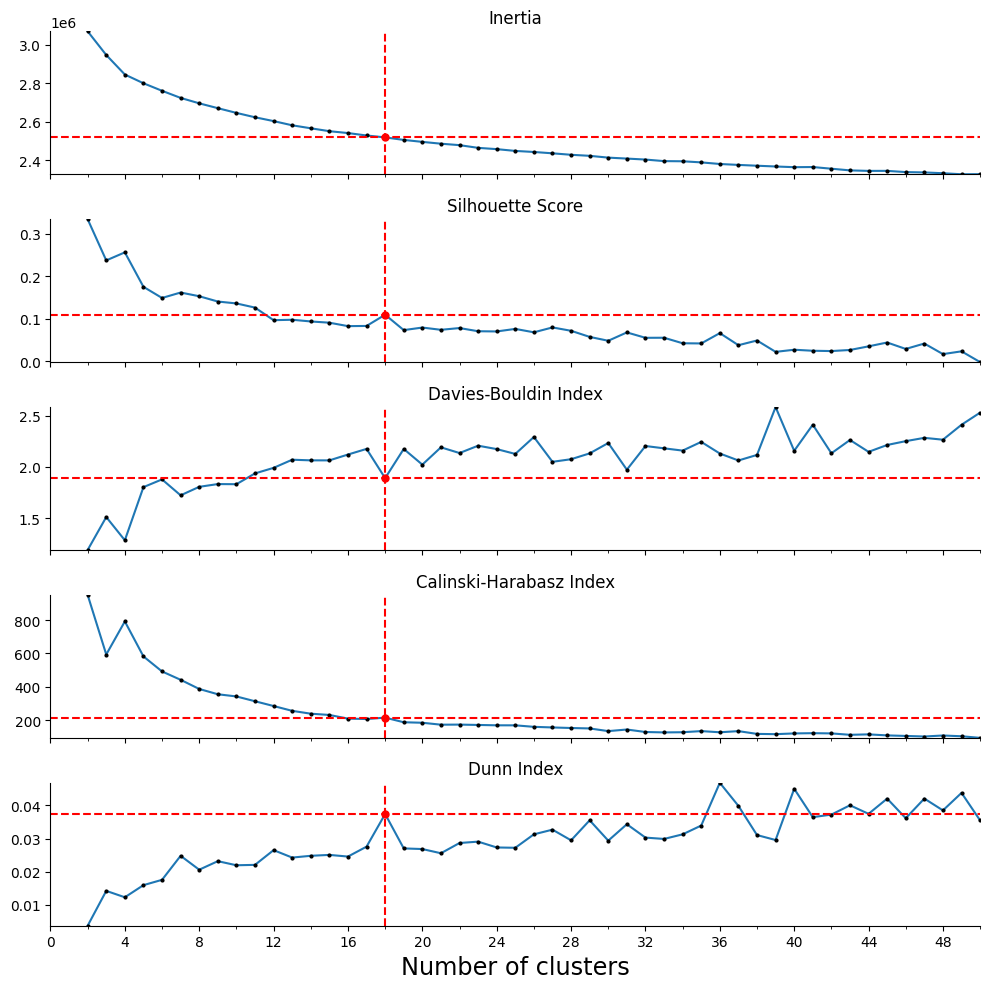

In [18]:
fig, axes = plt.subplots(len(evaulation_metric_scores), 1, figsize=(10, 2*len(evaulation_metric_scores)), sharex=True)
major_tick_interval = 4
minor_tick_interval = 2
chosen_n_clusters = 18
print(f"Number of samples to cluster: {len(data_original.index)}")
# Initialize minimum and maximums
for idx, (ax, metric_key) in enumerate(zip(axes.flatten(), list(evaulation_metric_scores))):
    n_clusters = list(evaulation_metric_scores[metric_key].keys())
    scores = list(evaulation_metric_scores[metric_key].values())
    ax.plot(n_clusters, scores, marker="o", markerfacecolor="black", markeredgecolor="black", markersize=2)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(major_tick_interval))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(minor_tick_interval))
    ax.set_title(metric_key)
    if idx == len(evaulation_metric_scores) - 1:
        ax.set_xlabel("Number of clusters", fontsize="xx-large")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if chosen_n_clusters < len(data_original.index):
        ax.vlines(chosen_n_clusters, min(scores), max(scores), linestyle="--", color="red")
        ax.hlines(evaulation_metric_scores[metric_key][chosen_n_clusters], xmin=0, xmax=n_clusters[-1], linestyle="--", color="red")
        ax.plot(chosen_n_clusters, evaulation_metric_scores[metric_key][chosen_n_clusters], marker="o", markerfacecolor="red", markeredgecolor="red", markersize=5)
    ax.set_xlim(0, n_clusters[-1])
    ax.set_ylim(min(scores), max(scores))
fig.tight_layout()

##### Use clusters to form representative samples

In [19]:
cluster_start_num = 1
# Load protein copy numbers
df_copy_numbers = pd.read_csv(processed_data_dirpath / "ProteinCopyNumbers.csv", index_col=sample_key)
# Load MCH for transforming data
df_MCH = pd.read_csv(processed_data_dirpath / "MCH.csv", index_col=sample_key)

df_copy_numbers = df_copy_numbers.loc[list(df_data_samples.index)].copy()
df_MCH = df_MCH.loc[list(df_data_samples.index)].copy()
if grouped_data_key.endswith("Donor"):
    df_copy_numbers.index = [x.split("_")[0] for x in df_copy_numbers.index]
    df_copy_numbers = df_copy_numbers.groupby(level=0).mean()

    df_MCH.index = [x.split("_")[0] for x in df_MCH.index]
    df_MCH = df_MCH.groupby(level=0).mean()


(processed_clusters_dirpath / genotype).mkdir(exist_ok=True, parents=True)
if chosen_n_clusters < len(data_original.index):
    cluster_labels = dataframes_of_label_maps[chosen_n_clusters] + cluster_start_num
    cluster_mapping.update(dict(zip(list(data_original.index), cluster_labels)))
    
    df_copy_numbers_clustered = df_copy_numbers.loc[list(data_original.index)].copy()
    df_copy_numbers_clustered = df_copy_numbers_clustered.rename(cluster_mapping, axis=0)
    df_copy_numbers_clustered = df_copy_numbers_clustered.groupby(level=0).mean()
    df_copy_numbers_clustered.index = [f"Allele{allele_count}_C{int(x)}" for x in df_copy_numbers_clustered.index]
    df_copy_numbers_clustered.to_csv(processed_clusters_dirpath / genotype / f"{grouped_data_key}_Alleles{allele_count}_ClusterCopyNumbers.csv", index=True)
    
    
    df_MCH_clustered  = df_MCH.loc[list(data_original.index)].copy()
    df_MCH_clustered  = df_MCH_clustered .rename(cluster_mapping, axis=0)
    df_MCH_clustered  = df_MCH_clustered .groupby(level=0).mean()
    df_MCH_clustered.index = [f"Allele{allele_count}_C{int(x)}" for x in df_MCH_clustered.index]
    df_MCH_clustered.to_csv(processed_clusters_dirpath / genotype / f"{grouped_data_key}_Alleles{allele_count}_ClusterMCH.csv", index=True)
    if save_figures:
        fig.savefig(
            processed_clusters_dirpath / genotype / f"{grouped_data_key}_Alleles{allele_count}_ClusterMetrics.{imagetype}",
            transparent=transparent,
            format=imagetype,
        )
    cluster_start_num += chosen_n_clusters
else:
    df_copy_numbers_clustered = data_original.copy()
df_copy_numbers_clustered

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
Allele0_C1,43930.248797,3273.497819,40622.307559,157.599207,225176.915886,2363.929891,11152.795020,9939.639820,15146.895724,25673.015606,...,3490.975722,336.176909,13752.077429,38778.026517,557.841725,10663.659091,5616.256538,35030.100425,12966.923746,4211.183908
Allele0_C2,80309.565147,5550.340756,88770.375761,189.308032,412349.999394,3355.301965,20477.600093,75251.692237,23010.625615,111939.170442,...,2062.264604,410.352518,17376.250090,38491.785885,381.817126,11491.105725,3405.674099,45459.755727,12254.571110,3316.221392
Allele0_C3,84148.091143,26649.083079,46137.056967,142.136889,231791.401174,2065.354449,11656.782678,45581.198027,267976.947930,140470.648954,...,2559.270996,544.803248,17899.198025,31383.394064,413.836901,10145.903801,5831.573072,23464.703121,11287.341443,4066.543091
Allele0_C4,88917.359598,5922.035505,79993.077650,47.588973,279159.379838,3860.122539,17190.348073,20539.121681,82848.598092,52688.023821,...,2731.782325,318.965367,8162.865146,20132.175054,235.742308,9561.512121,5769.292907,17694.800880,9842.420820,1952.296829
Allele0_C5,33682.902535,1013.857852,127288.760493,27.335303,588280.050801,3676.589074,18936.633093,14049.784597,2226.652081,43510.573444,...,2899.754810,34.543501,29996.913961,69216.651464,69.870812,11912.176969,1851.869267,21789.853239,14085.376738,3706.552299
Allele0_C6,152628.771529,16347.188942,67572.603496,676.712942,274528.679882,4383.682100,31012.790476,62266.151666,200104.644621,85938.788966,...,1935.128168,279.601921,19381.659875,33625.380145,305.077645,10542.459055,4409.683433,35816.015965,12872.533956,2949.139221
Allele0_C7,56646.658970,64.289996,87039.937674,58.591850,484459.143336,3160.613200,18183.243877,23035.499372,4607.275756,60214.373573,...,2483.161599,167.637206,17554.999016,55660.024300,343.717068,11218.120175,3426.721674,28337.189572,12497.891801,4311.825238
Allele0_C8,58961.924274,2862.908284,90271.545234,68.626761,634057.240717,9308.230832,38777.553539,11620.345895,348.972438,50019.293573,...,2940.627602,124.370835,18267.001536,22983.974594,0.000000,13636.033413,1286.193761,4363.259473,14554.369761,4778.414839
Allele0_C9,62098.304209,2048.793911,30995.274164,10.957573,265709.245147,1639.958456,11149.994591,23922.333920,44618.469031,31781.471161,...,2242.286663,240.154518,10388.920851,11805.132433,367.153181,12944.793908,4233.316280,20204.219562,13235.480110,3460.786119
Allele0_C10,81323.303192,1586.084870,58349.446367,45.647180,211450.670439,2881.508307,14202.157761,23831.145484,53427.359977,29040.734946,...,2387.549276,311.378420,16018.646019,37519.086013,448.040624,11467.703337,3625.628310,33415.540112,14116.044182,2951.061230


#### Allele count: 1

In [20]:
allele_count = 1
verbose = True
data_original = dict_of_genotype_dfs[(genotype, allele_count)].copy()
data_original.index.name = sample_key
data_original.columns.name = "Proteins"
data_original

Proteins,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S049_D10,-0.171829,2.015546,-0.022391,-0.285478,-0.549121,-0.794563,-0.797139,1.216839,2.518091,0.434845,...,-0.593514,-0.385745,0.058670,-0.864634,-0.470972,-0.832617,0.113849,-0.214435,-0.092771,-0.635815
S049_D23,0.047896,-0.498573,-0.641978,3.501067,-0.440318,-0.530983,-0.393296,0.456017,1.101481,0.149776,...,-0.932457,-0.385745,0.466782,-0.864634,-0.470972,-1.343481,-0.275020,-0.373638,-0.462327,-0.656624
S049_D42,-0.676690,0.577059,0.900123,-0.285478,1.586691,0.801968,-0.075348,1.842671,0.629085,-0.169032,...,-0.640755,-0.385745,0.121308,0.030843,-0.470972,-0.914535,0.106612,-0.317069,-1.076143,-0.573431
S068_D10,-0.410941,-0.498573,-0.641978,-0.285478,-0.341267,-0.794563,1.757668,-0.746079,-0.705019,0.050998,...,1.264814,-0.385745,-0.573989,-0.864634,-0.470972,0.085978,-0.151146,3.744602,0.563144,0.448975
S068_D23,0.185602,-0.498573,-0.641978,-0.285478,-0.254242,-0.594004,0.033637,0.633222,-0.705019,0.127632,...,-0.467550,-0.385745,0.641140,-0.539953,-0.470972,-0.646759,-0.060010,-0.373638,-0.532850,1.837278
S068_D42,-0.927649,-0.498573,-0.313430,-0.285478,-0.296668,-0.794563,2.166587,-0.746079,-0.705019,-0.250237,...,-0.091512,-0.385745,0.799230,-0.864634,-0.470972,0.784907,1.276936,-0.373638,-0.372265,-1.525761
S120_D10,-1.325710,-0.498573,-0.575163,-0.285478,-0.589054,-0.794563,-1.301151,0.061224,-0.705019,-0.512589,...,1.032710,-0.385745,0.578710,1.069727,-0.470972,1.758391,1.083785,-0.373638,-0.913043,-0.613762
S120_D23,-0.927764,2.929075,-0.641978,-0.285478,-1.173636,-0.594004,-1.428784,-0.746079,0.370747,0.930635,...,2.206525,-0.385745,0.668502,-0.553040,-0.470972,0.060271,0.036443,-0.149233,1.331794,-0.294094
S120_D42,-1.325710,-0.498573,0.756518,-0.285478,-0.779653,-0.794563,-1.428784,-0.746079,-0.705019,-1.224794,...,0.189128,-0.385745,-0.140010,1.696043,-0.470972,1.427409,2.067918,-0.373638,0.988453,-1.525761


#### K-means clustering
##### Determine optimal number of clusters for representative models

In [21]:
evaulation_metric_scores = defaultdict(dict)
dataframes_of_clusters = {}
dataframes_of_label_maps = {}
kmax = min(50, len(data_original) - 1)
verbose = False
for n_clusters in range(2, kmax + 1):
    
    kmeans = sklearn.cluster.KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=50,
        max_iter=int(1e9),
        tol=1e-12,
        verbose=0,
        random_state=44,
        algorithm="lloyd",
    )
    # Clustering occurs on columns, goal is to reduce sample number so data format is (n_features, n_samples)
    data_clustered = kmeans.fit_transform(data_original.values)
    # Inertia (Within-cluster sum-of-squares)
    inertia = kmeans.inertia_
    evaulation_metric_scores["Inertia"][n_clusters] = inertia
    # Silhouette Score
    evaulation_metric_scores["Silhouette Score"][n_clusters] = silhouette_score(
        data_clustered, # (n_samples, n_features)
        kmeans.labels_,
        metric='euclidean',
        sample_size=None,
        random_state=None,
    )
    # Davies-Bouldin Index
    evaulation_metric_scores["Davies-Bouldin Index"][n_clusters] = davies_bouldin_score(data_clustered, kmeans.labels_)
    # Calinski-Harabasz Index
    evaulation_metric_scores["Calinski-Harabasz Index"][n_clusters] = calinski_harabasz_score(data_clustered, kmeans.labels_)
    evaulation_metric_scores["Dunn Index"][n_clusters] = calculate_dunn_index(data_clustered, kmeans.labels_)
    if verbose:
        header = f"For K-means clustering: K = {n_clusters}"
        
        print(f"{header}\n{'='*len(header)}") 
        for metric_key in list(evaulation_metric_scores):
            score = evaulation_metric_scores[metric_key][n_clusters]
            print(f"{metric_key}: {score:.4f}")
        print()

    # Save as DataFame
    data_clustered = pd.DataFrame(data_clustered, index=data_original.index)
    data_clustered.index.name = "Proteins"
    data_clustered.columns.name = "Cluster"
    dataframes_of_clusters[n_clusters] = data_clustered
    dataframes_of_label_maps[n_clusters] = kmeans.labels_

#### Plot evaluation metric scores
##### Inertia
Measures the compactness of clusters by calculating the sum of squared distances between each data point and its centroid. Lower inertia generally indicates tighter, more cohesive clusters.
##### Silhouette Score
Measures how well each data point fits within its assigned cluster compared to other clusters. A higher score (closer to 1) indicates better clustering. 
##### Davies-Bouldin Index
Measures the average similarity between each cluster and its most similar cluster. A lower score indicates better separation between clusters. 
##### Calinski-Harabasz Index
Measures the ratio of between-cluster dispersion to within-cluster dispersion. A higher score indicates better clustering. 
##### Dunn Index:
Measures the ratio of the shortest distance between clusters to the largest distance within a cluster. A higher score indicates better separation and compactness. 

Number of samples to cluster: 35


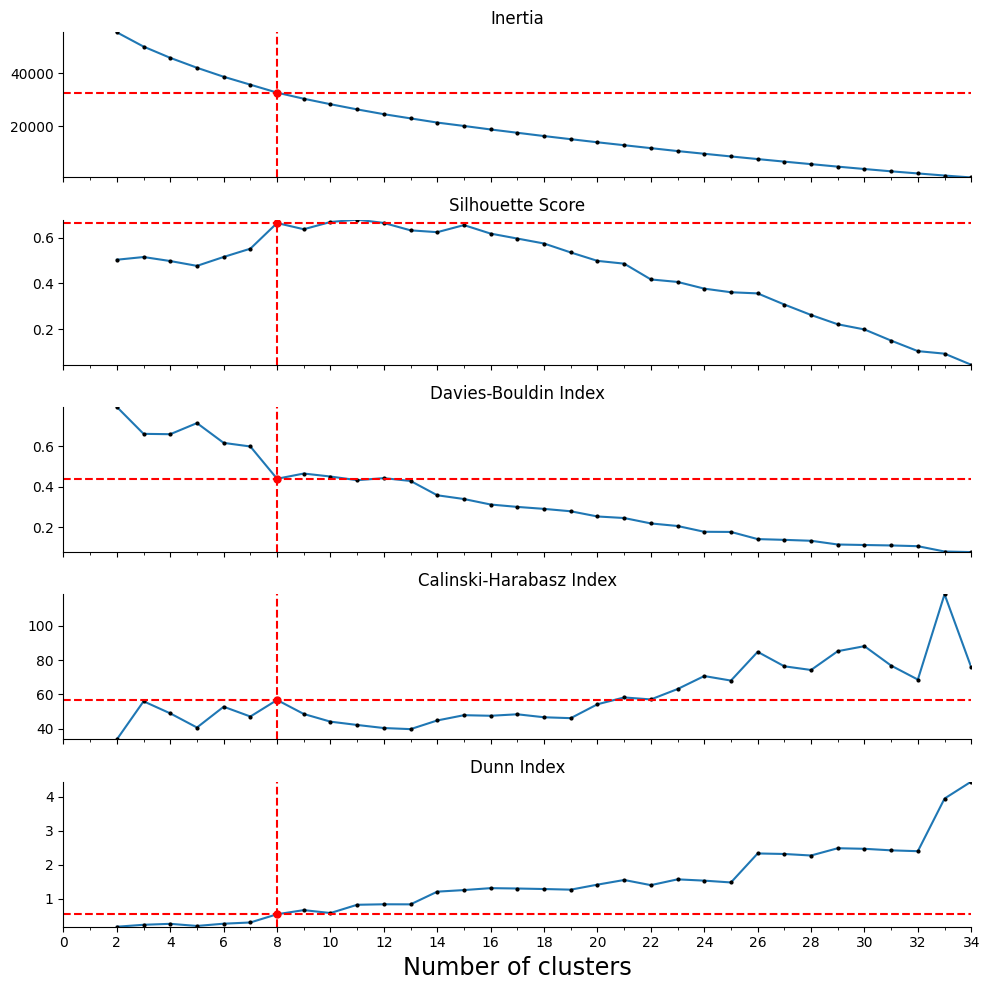

In [22]:
fig, axes = plt.subplots(len(evaulation_metric_scores), 1, figsize=(10, 2*len(evaulation_metric_scores)), sharex=True)
major_tick_interval = 2
minor_tick_interval = 1
chosen_n_clusters = 8
print(f"Number of samples to cluster: {len(data_original.index)}")
# Initialize minimum and maximums

for idx, (ax, metric_key) in enumerate(zip(axes.flatten(), list(evaulation_metric_scores))):
    n_clusters = list(evaulation_metric_scores[metric_key].keys())
    scores = list(evaulation_metric_scores[metric_key].values())
    ax.plot(n_clusters, scores, marker="o", markerfacecolor="black", markeredgecolor="black", markersize=2)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(major_tick_interval))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(minor_tick_interval))
    ax.set_title(metric_key)
    if idx == len(evaulation_metric_scores) - 1:
        ax.set_xlabel("Number of clusters", fontsize="xx-large")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if chosen_n_clusters < len(data_original.index):
        ax.vlines(chosen_n_clusters, min(scores), max(scores), linestyle="--", color="red")
        ax.hlines(evaulation_metric_scores[metric_key][chosen_n_clusters], xmin=0, xmax=n_clusters[-1], linestyle="--", color="red")
        ax.plot(chosen_n_clusters, evaulation_metric_scores[metric_key][chosen_n_clusters], marker="o", markerfacecolor="red", markeredgecolor="red", markersize=5)
    ax.set_xlim(0, n_clusters[-1])
    ax.set_ylim(min(scores), max(scores))
fig.tight_layout()

##### Use clusters to form representative samples

In [23]:
# Load protein copy numbers
df_copy_numbers = pd.read_csv(processed_data_dirpath / "ProteinCopyNumbers.csv", index_col=sample_key)

# Load MCH for transforming data
df_MCH = pd.read_csv(processed_data_dirpath / "MCH.csv", index_col=sample_key)

df_copy_numbers = df_copy_numbers.loc[list(df_data_samples.index)].copy()
df_MCH = df_MCH.loc[list(df_data_samples.index)].copy()
if grouped_data_key.endswith("Donor"):
    df_copy_numbers.index = [x.split("_")[0] for x in df_copy_numbers.index]
    df_copy_numbers = df_copy_numbers.groupby(level=0).mean()

    df_MCH.index = [x.split("_")[0] for x in df_MCH.index]
    df_MCH = df_MCH.groupby(level=0).mean()


(processed_clusters_dirpath / genotype).mkdir(exist_ok=True, parents=True)
if chosen_n_clusters < len(data_original.index):
    cluster_labels = dataframes_of_label_maps[chosen_n_clusters] + cluster_start_num
    cluster_mapping.update(dict(zip(list(data_original.index), cluster_labels)))
    
    df_copy_numbers_clustered = df_copy_numbers.loc[list(data_original.index)].copy()
    df_copy_numbers_clustered = df_copy_numbers_clustered.rename(cluster_mapping, axis=0)
    df_copy_numbers_clustered = df_copy_numbers_clustered.groupby(level=0).mean()
    df_copy_numbers_clustered.index = [f"Allele{allele_count}_C{int(x)}" for x in df_copy_numbers_clustered.index]
    df_copy_numbers_clustered.to_csv(processed_clusters_dirpath / genotype / f"{grouped_data_key}_Alleles{allele_count}_ClusterCopyNumbers.csv", index=True)
    
    
    df_MCH_clustered  = df_MCH.loc[list(data_original.index)].copy()
    df_MCH_clustered  = df_MCH_clustered .rename(cluster_mapping, axis=0)
    df_MCH_clustered  = df_MCH_clustered .groupby(level=0).mean()
    df_MCH_clustered.index = [f"Allele{allele_count}_C{int(x)}" for x in df_MCH_clustered.index]
    df_MCH_clustered.to_csv(processed_clusters_dirpath / genotype / f"{grouped_data_key}_Alleles{allele_count}_ClusterMCH.csv", index=True)
    if save_figures:
        fig.savefig(
            processed_clusters_dirpath / genotype / f"{grouped_data_key}_Alleles{allele_count}_ClusterMetrics.{imagetype}",
            transparent=transparent,
            format=imagetype,
        )
    cluster_start_num += chosen_n_clusters
else:
    df_copy_numbers_clustered = data_original.copy()
df_copy_numbers_clustered

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
Allele1_C19,66449.786071,0.000000,12364.958560,0.000000,289980.048454,317.343380,44870.270934,24043.274867,0.000000,76220.391472,...,2502.909800,0.000000,19211.011456,4322.581568,0.000000,11402.539601,4201.409764,70174.107822,11383.260389,3206.481546
Allele1_C20,125576.688784,16351.599474,14767.665769,0.000000,464161.353804,5706.180582,23378.113098,84200.335600,55157.961055,62278.493549,...,2089.282876,28.096991,14915.569811,34058.470082,259.167271,13130.132197,1706.941667,44382.489567,11902.039239,2065.091884
Allele1_C21,10188.195463,0.000000,0.000000,0.000000,450438.484230,3703.165033,6342.089645,0.000000,0.000000,5624.474373,...,1202.998444,0.000000,32564.928117,67121.328001,0.000000,12427.106933,582.245199,0.000000,15355.330603,5783.182626
Allele1_C22,216976.731370,14554.979290,34877.480328,2417.511450,369191.629045,5462.644879,31213.719888,16672.471551,135851.949038,54617.887385,...,2266.023875,0.000000,10681.171945,1790.752645,0.000000,10055.028960,3439.515793,48584.662884,7739.783912,2142.590488
Allele1_C23,10210.322722,39863.796882,44221.064343,0.000000,171996.730811,343.093139,593.028977,12732.931700,51481.320515,63272.756743,...,4014.948805,0.000000,18942.254973,54972.882086,0.000000,13581.971812,5451.384591,3726.439250,13197.933422,1703.003189
Allele1_C24,153311.683753,60481.543213,71401.283742,1361.457877,298850.032905,2585.726548,18991.795203,53999.795453,267548.640222,116056.596077,...,1335.200496,663.427155,22563.948662,48125.073647,471.273173,10555.165086,10105.482513,81078.379488,11657.930597,2778.327236
Allele1_C25,0.000000,16651.607100,182710.605447,0.000000,993921.547130,7392.127537,43127.309926,172197.667292,46643.207929,85082.533588,...,1804.215066,1421.992485,10866.468734,0.000000,0.000000,10493.284134,1429.712064,7895.439588,17150.279103,4708.625158
Allele1_C26,176171.873111,0.000000,565470.928447,1948.733503,354552.842801,25168.156253,62027.321634,0.000000,94659.726746,135370.579907,...,1471.258498,0.000000,10309.347901,10465.772507,0.000000,12989.379778,1555.691901,0.000000,8232.626276,1992.773650


### Concat data to create final set

In [24]:
cluster_count = 0
allele_counts = [0, 1, 2]
df_genotypes = pd.read_csv(processed_clusters_dirpath / genotype / f"{grouped_data_key}_Genotypes.csv", index_col=0)

copy_number_dfs_to_concat = []
MCH_dfs_to_concat = []
for allele_count in allele_counts:
    try:
        df_copy_numbers_allele = pd.read_csv(processed_clusters_dirpath / genotype / f"{grouped_data_key}_Alleles{allele_count}_ClusterCopyNumbers.csv", index_col=0)
        df_MCH_allele = pd.read_csv(processed_clusters_dirpath / genotype / f"{grouped_data_key}_Alleles{allele_count}_ClusterMCH.csv", index_col=0)
        # Count number of existing clusters
        cluster_count += len(df_copy_numbers_allele.index)
    except FileNotFoundError:
        df_copy_numbers_allele = df_copy_numbers.loc[list(df_genotypes[(df_genotypes == allele_count).values].index)]
        cluster_mapping.update({sample_id: idx + cluster_count for idx, sample_id in enumerate(df_copy_numbers_allele.index, start=1)})
        df_copy_numbers_allele.index = [f"Allele{allele_count}_{x}" for x in df_copy_numbers_allele.index]
        # Set cluster for donors with allele count 2 as final cluster

        df_MCH_allele = df_MCH.loc[list(df_genotypes[(df_genotypes == allele_count).values].index)]
        df_MCH_allele.index = [f"Allele{allele_count}_{x}" for x in df_MCH_allele.index]

    copy_number_dfs_to_concat += [df_copy_numbers_allele]
    MCH_dfs_to_concat += [df_MCH_allele]


operations = ["Mean", "Median"]
df_copy_numbers_representative = pd.concat(copy_number_dfs_to_concat)
to_concat = []
for op in operations:
    df = df_copy_numbers_representative.copy()
    df.index = [x.split("_")[0] for x in df.index]
    df = getattr(df.groupby(level=0), op.lower())()
    df.index = ["_".join((op.capitalize(), x)) for x in df.index]
    to_concat += [df]
df_copy_numbers_representative = pd.concat((df_copy_numbers_representative, *to_concat), axis=0)

df_MCH_representative = pd.concat(MCH_dfs_to_concat)
to_concat = []
for op in operations:
    df = df_MCH_representative.copy()
    df.index = [x.split("_")[0] for x in df.index]
    df = getattr(df.groupby(level=0), op.lower())()
    df.index = ["_".join((op.capitalize(), x)) for x in df.index]
    to_concat += [df]
df_MCH_representative = pd.concat((df_MCH_representative, *to_concat), axis=0)

df_cluster_mapping = pd.DataFrame.from_dict(cluster_mapping, orient="index", columns=["CLUSTER"])
df_cluster_mapping.index.name = sample_key
df_cluster_mapping.to_csv(processed_clusters_dirpath / genotype / f"{grouped_data_key}_ClusterMapping.csv", index=True)
df_copy_numbers_representative.to_csv(processed_clusters_dirpath / genotype / f"{genotype}_{grouped_data_key}_ClusterCopyNumbers.csv", index=True)
df_MCH_representative.to_csv(processed_clusters_dirpath / genotype / f"{genotype}_{grouped_data_key}_ClusterMCH.csv", index=True)
df_copy_numbers_representative

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
Allele0_C1,43930.248797,3273.497819,40622.307559,157.599207,225176.915886,2363.929891,11152.795020,9939.639820,15146.895724,25673.015606,...,3490.975722,336.176909,13752.077429,38778.026517,557.841725,10663.659091,5616.256538,35030.100425,12966.923746,4211.183908
Allele0_C2,80309.565147,5550.340756,88770.375761,189.308032,412349.999394,3355.301965,20477.600093,75251.692237,23010.625615,111939.170442,...,2062.264604,410.352518,17376.250090,38491.785885,381.817126,11491.105725,3405.674099,45459.755727,12254.571110,3316.221392
Allele0_C3,84148.091143,26649.083079,46137.056967,142.136889,231791.401174,2065.354449,11656.782678,45581.198027,267976.947930,140470.648954,...,2559.270996,544.803248,17899.198025,31383.394064,413.836901,10145.903801,5831.573072,23464.703121,11287.341443,4066.543091
Allele0_C4,88917.359598,5922.035505,79993.077650,47.588973,279159.379838,3860.122539,17190.348073,20539.121681,82848.598092,52688.023821,...,2731.782325,318.965367,8162.865146,20132.175054,235.742308,9561.512121,5769.292907,17694.800880,9842.420820,1952.296829
Allele0_C5,33682.902535,1013.857852,127288.760493,27.335303,588280.050801,3676.589074,18936.633093,14049.784597,2226.652081,43510.573444,...,2899.754810,34.543501,29996.913961,69216.651464,69.870812,11912.176969,1851.869267,21789.853239,14085.376738,3706.552299
Allele0_C6,152628.771529,16347.188942,67572.603496,676.712942,274528.679882,4383.682100,31012.790476,62266.151666,200104.644621,85938.788966,...,1935.128168,279.601921,19381.659875,33625.380145,305.077645,10542.459055,4409.683433,35816.015965,12872.533956,2949.139221
Allele0_C7,56646.658970,64.289996,87039.937674,58.591850,484459.143336,3160.613200,18183.243877,23035.499372,4607.275756,60214.373573,...,2483.161599,167.637206,17554.999016,55660.024300,343.717068,11218.120175,3426.721674,28337.189572,12497.891801,4311.825238
Allele0_C8,58961.924274,2862.908284,90271.545234,68.626761,634057.240717,9308.230832,38777.553539,11620.345895,348.972438,50019.293573,...,2940.627602,124.370835,18267.001536,22983.974594,0.000000,13636.033413,1286.193761,4363.259473,14554.369761,4778.414839
Allele0_C9,62098.304209,2048.793911,30995.274164,10.957573,265709.245147,1639.958456,11149.994591,23922.333920,44618.469031,31781.471161,...,2242.286663,240.154518,10388.920851,11805.132433,367.153181,12944.793908,4233.316280,20204.219562,13235.480110,3460.786119
Allele0_C10,81323.303192,1586.084870,58349.446367,45.647180,211450.670439,2881.508307,14202.157761,23831.145484,53427.359977,29040.734946,...,2387.549276,311.378420,16018.646019,37519.086013,448.040624,11467.703337,3625.628310,33415.540112,14116.044182,2951.061230


In [ ]:
asdasdasdasdasdasd

In [ ]:
umap = sklearn.manifold.LocallyLinearEmbedding(
    n_neighbors=10,
    n_components=2,
    reg=1e-9,
    eigen_solver="dense",
    max_iter=int(1e9),
    method="ltsa",
    hessian_tol=1e-4,
    modified_tol=1e-12,
    neighbors_algorithm="auto",
    # random_state=4,
    n_jobs=10,
)
transformed = umap.fit_transform(data_original.values)
# ax = plt.scatter(*transformed.T)
df = pd.DataFrame(transformed, index=data_original.merge(df_metadata, left_index=True, right_index=True)[genotype].index)
df = df.merge(df_metadata[genotype], left_index=True, right_index=True)
df.plot.scatter(x=0, y=1, c=df[genotype])

In [ ]:
umap = sklearn.manifold.MDS(
    n_components=2,
    metric=True,
    n_init=10,
    max_iter=int(1e9),
    verbose=0,
    eps=1e-6,
    n_jobs=10,
    random_state=4,
    dissimilarity="euclidean",
)
transformed = umap.fit_transform(data_original.values)
# ax = plt.scatter(*transformed.T)
df = pd.DataFrame(transformed, index=data_original.merge(df_metadata, left_index=True, right_index=True)[genotype].index)
df = df.merge(df_metadata[genotype], left_index=True, right_index=True)
df.plot.scatter(x=0, y=1, c=df[genotype])

In [ ]:
umap = sklearn.manifold.TSNE(
    n_components=2,
    perplexity=50,
    # reg=1e-9,
    # eigen_solver="dense",
    # max_iter=int(1e9),
    # method="standard",
    # hessian_tol=1e-4,
    # modified_tol=1e-12,
    # neighbors_algorithm="auto",
    # random_state=4,
    n_jobs=10,
)
transformed = umap.fit_transform(data_original.values)
# ax = plt.scatter(*transformed.T)
df = pd.DataFrame(transformed, index=data_original.merge(df_metadata, left_index=True, right_index=True)[genotype].index)
df = df.merge(df_metadata[genotype], left_index=True, right_index=True)
df.plot.scatter(x=0, y=1, c=df[genotype])

In [ ]:
silhouette_avg_dict = {}
wcss_dict = {}
for n_clusters in range(2, 50):
    
    kmeans = sklearn.cluster.KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=10,
        max_iter=int(1e6),
        tol=1e-9,
        verbose=0,
        random_state=4,
        algorithm="lloyd",
    )
    # Shape is (n_samples, n_features), goal is to reduce sample number to transpose data
    data_original = data.T
    data_clustered = kmeans.fit_transform(data_original.values)
    data_clustered = pd.DataFrame(data_clustered.T, columns=data.columns)

    wcss_dict[n_clusters] = kmeans.inertia_
    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = sklearn.metrics.silhouette_score(data_original.values, kmeans.labels_)
    silhouette_avg_dict[n_clusters] = silhouette_avg
    # fig, ax1 = plt.subplots(1, 1)
    # fig.set_size_inches(4, 4)

    # # The 1st subplot is the silhouette plot
    # # The silhouette coefficient can range from -1, 1 but in this example all
    # # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # # plots of individual clusters, to demarcate them clearly.
    # ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # y_lower = 10
    # for i in range(n_clusters):
    #     # Aggregate the silhouette scores for samples belonging to
    #     # cluster i, and sort them
    #     ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]

    #     ith_cluster_silhouette_values.sort()

    #     size_cluster_i = ith_cluster_silhouette_values.shape[0]
    #     y_upper = y_lower + size_cluster_i

    #     color = cm.nipy_spectral(float(i) / n_clusters)
    #     ax1.fill_betweenx(
    #         np.arange(y_lower, y_upper),
    #         0,
    #         ith_cluster_silhouette_values,
    #         facecolor=color,
    #         edgecolor=color,
    #         alpha=0.7,
    #     )

    #     # Label the silhouette plots with their cluster numbers at the middle
    #     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    #     # Compute the new y_lower for next plot
    #     y_lower = y_upper + 10  # 10 for the 0 samples
        
    # ax1.set_title("The silhouette plot for the various clusters.")
    # ax1.set_xlabel("The silhouette coefficient values")
    # ax1.set_ylabel("Cluster label")

    # # The vertical line for average silhouette score of all the values
    # ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # ax1.set_yticks([])  # Clear the yaxis labels / ticks
    # ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])